In [6]:
%matplotlib inline
import cmlreaders as cml
import pybeh_pd as pb
import numpy as np
import seaborn as sns
import pandas as pd

In [7]:
all_catfr1_events = cml.CMLReader.load_events(experiments=["catFR1"], data_type='task_events')

In [8]:
events = all_catfr1_events.query('type == ["WORD", "REC_WORD"]')
events = events[events['list'] > 0] # removing practice lists

In [9]:
#removing subjects who were presented with the same word multiple times (probably repeated data)
word_evs = events.query('type == "WORD"')
n_word_pres = word_evs.groupby(['subject', 'session', 'list', 'item_num'], as_index=False).size()
bad_lists = n_word_pres.query('size > 2')
bad_lists[['subject', 'session', 'list']].drop_duplicates()
bad_subs = bad_lists.subject.unique().tolist()

#drop subjects without 12 items per list
n_list_pres = word_evs.groupby(['subject', 'session', 'list'], as_index=False).size()
bad_lists = n_list_pres.query('size != 12')
bad_subs += bad_lists.subject.unique().tolist()

#drop subjects with no recalls
n_types = events.groupby('subject', as_index=False).agg({'type': 'nunique'})
no_recall_subs = n_types.query('type != 2')
bad_subs += no_recall_subs.subject.unique().tolist()

#drop subjects with messed up recalls
rec_evs = events.query('type == "REC_WORD"')
joint_evs = word_evs.merge(rec_evs[['subject', 'session', 'list', 'category', 'item_name']], how='left', indicator=True)
bad_subs += joint_evs.query('(recalled == 1 and _merge != "both") or (recalled == 0 and _merge == "both")').subject.unique().tolist()

events.query('subject not in @bad_subs', inplace=True)

In [10]:
word_evs = events.query('type == "WORD"')
rec_evs = events.query('type == "REC_WORD"')

In [11]:
spc_sess_df = word_evs.groupby(['subject', 'session', 'serialpos'], as_index=False).agg({'recalled': 'mean'})
spc_df = spc_sess_df.groupby(['subject', 'serialpos'], as_index=False).agg({'recalled': 'mean'})

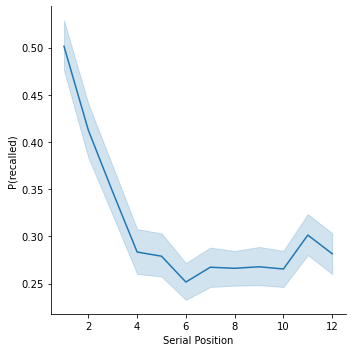

In [12]:
g = sns.relplot(x='serialpos', y='recalled', data=spc_df, kind='line')
g.set(xlabel='Serial Position', ylabel='P(recalled)')

In [13]:
rec_evs['outpos'] = rec_evs.groupby(['subject', 'session', 'list']).cumcount()
n_list_df = word_evs.groupby(['subject', 'session']).agg({'list': 'nunique'}).reset_index().rename(columns={'list': 'n_lists'})
first_recall_sess_df = rec_evs.query('outpos == 0 and serialpos != -999')
#make sure there are 0s in serialpos that never get recalled first
first_recall_sess_df = first_recall_sess_df.groupby(
    ['subject', 'session', 'serialpos']).agg(
    {'recalled': 'count'}).unstack(fill_value=0).stack().reset_index()
first_recall_sess_df = first_recall_sess_df.merge(n_list_df)
first_recall_sess_df['pfr'] = first_recall_sess_df['recalled'] / first_recall_sess_df['n_lists']
pfr_df = first_recall_sess_df.groupby(['subject', 'serialpos']).agg({'pfr': 'mean'}).reset_index()

/home1/djhalp/.conda/envs/cml/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


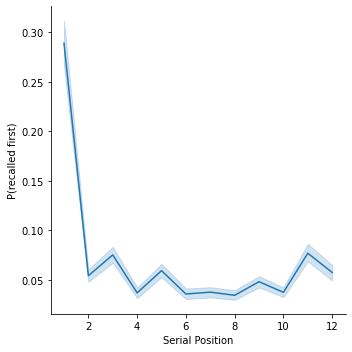

In [14]:
g = sns.relplot(x='serialpos', y='pfr', data=pfr_df, kind='line')
g.set(xlabel='Serial Position', ylabel='P(recalled first)')

In [15]:
pb_crp = events.groupby('subject').apply(pb.pd_crp, 
                                itemno_column='item_num').reset_index()

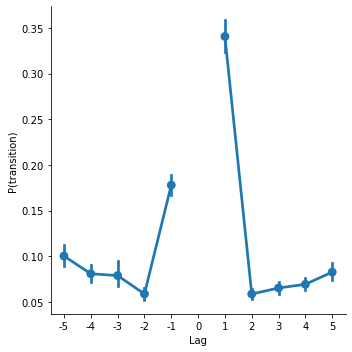

In [16]:
g = sns.catplot(x='lag', y='prob', kind='point', 
                  data=pb_crp.query('lag <= 5 and lag >= -5')
           )
g.set(xlabel='Lag', ylabel='P(transition)')

In [16]:
pb_temp_fact = events.groupby("subject").apply(pb.pd_temp_fact,
                                                   itemno_column='item_num', 
                                                   list_index=['subject', 'session', 'list'], 
                                                   pres_type="WORD", rec_type="REC_WORD", type_column='type'
                                                   ).to_frame(name='temp_fact').reset_index()

pb_temp_fact

,subject,temp_fact
0,R1004D,0.677778
1,R1013E,0.614322
2,R1015J,0.584127
3,R1016M,0.598297
4,R1021D,0.630544
...,...,...
234,R1616S,0.551848
235,R1617S,0.604552
236,R1626S,0.583251
237,R1627T,0.488794


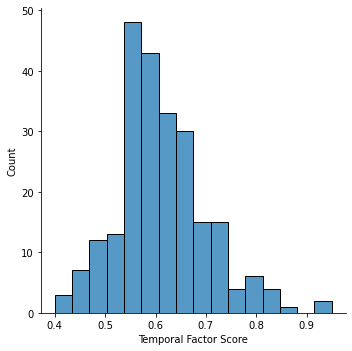

In [17]:
g = sns.displot(x='temp_fact', data=pb_temp_fact)
g.set(xlabel='Temporal Factor Score')

In [17]:
# replace item nums so they are consistent across subjects
item_col = 'item_name'
item_num_col = 'item_num'
item_num_df = events.query('type == "WORD"').drop_duplicates(subset=item_col, ignore_index=True
                                    )[item_col].reset_index().rename(columns={'index': item_num_col})
item_num_df['item_num'] = item_num_df['item_num'] + 1
events_new = events.merge(item_num_df, on=item_col, suffixes=('', '_new'), 
                          how='left', sort=False)#.sort_values('mstime')
events_new.fillna({'item_num_new': -999}, inplace=True)

In [2]:
import gensim.downloader
word2vec_vectors = gensim.downloader.load('word2vec-google-news-300')

In [3]:
def word_similarity(df, col1, col2, keyed_vector=None):
    try:
        return keyed_vector.similarity(df[col1].lower(), df[col2].lower())
    except:
        return np.nan

In [18]:
# get all pairs of items
items = item_num_df[item_col].values
sem_sim_df = pd.MultiIndex.from_product([items, items], names=['wordpool_item_1', 'wordpool_item_2']).to_frame(index=False)

In [19]:
sem_sim_df

,wordpool_item_1,wordpool_item_2
0,DESK,DESK
1,DESK,TABLE
2,DESK,CARROT
3,DESK,CUCUMBER
4,DESK,HAWK
...,...,...
364811,DIENTE,TERCIOPELO
364812,DIENTE,MEZCLILLA
364813,DIENTE,SEDA
364814,DIENTE,CHURRO


In [20]:
# compute similarity of all pairs
sem_sim_df['similarity'] = sem_sim_df.apply(word_similarity, 
               axis=1, col1='wordpool_item_1', 
               col2='wordpool_item_2', 
               keyed_vector=word2vec_vectors)

In [21]:
sem_sim_df.to_csv('/scratch/djh/catfr1_sem_sim_df.csv', index=False)

In [22]:
sem_sim_df = pd.read_csv('/scratch/djh/catfr1_sem_sim_df.csv')

In [25]:
sem_sim_num_df = sem_sim_df.merge(
    item_num_df, left_on='wordpool_item_1', right_on=item_col).merge(
    item_num_df, left_on='wordpool_item_2', right_on=item_col, suffixes=('_1', '_2')).drop(columns=['wordpool_item_1', 'wordpool_item_2'])

In [26]:
sem_sims = pd.pivot_table(sem_sim_num_df, index='item_num_1', columns='item_num_2', values='similarity', dropna=False)

In [27]:
events_new.query('item_num_new == -999')

,category,category_num,eegfile,eegoffset,exp_version,experiment,intrusion,is_stim,item_name,item_num,...,recognized,rectime,rejected,serialpos,session,stim_list,stim_params,subject,type,item_num_new
232,X,-999,R1004D_11Nov14_1100,5688532,1.02,catFR1,-1,False,DUCKS,-1,...,NaN,13978,NaN,-999,0,False,[],R1004D,REC_WORD,-999.0
272,X,-999,R1004D_11Nov14_1100,6323298,1.02,catFR1,-1,False,COBRA,-1,...,NaN,23021,NaN,-999,0,False,[],R1004D,REC_WORD,-999.0
323,X,-999,R1004D_11Nov14_1100,7043183,1.02,catFR1,-1,False,GOOD,-1,...,NaN,13739,NaN,-999,0,False,[],R1004D,REC_WORD,-999.0
847,X,-999,R1015J_catFR1_0_18Jan15_1549,2089087,1.03,catFR1,-1,False,STAND,-1,...,NaN,6157,NaN,-999,0,False,[],R1015J,REC_WORD,-999.0
878,X,-999,R1016M_catFR1_0_20Jan15_1032,589344,1.03,catFR1,-1,False,WATERMELON,-1,...,NaN,23553,NaN,-999,0,False,[],R1016M,REC_WORD,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141783,X,-999,R1627T_catFR1_0_03Aug22_1535,1073612,,catFR1,-1,False,PALM,-1,...,-999.0,9256,-999.0,-999,0,True,NaN,R1627T,REC_WORD,-999.0
141891,X,-999,R1627T_catFR1_1_05Aug22_1537,484242,,catFR1,-1,False,DRINK,-1,...,-999.0,19316,-999.0,-999,1,True,NaN,R1627T,REC_WORD,-999.0
141938,X,-999,R1627T_catFR1_1_05Aug22_1537,793260,,catFR1,-1,False,GROUND,-1,...,-999.0,22820,-999.0,-999,1,True,NaN,R1627T,REC_WORD,-999.0
141966,X,-999,R1637T_catFR1_0_13Oct22_1404,379686,,catFR1,-1,False,MOP,-1,...,-999.0,9743,-999.0,-999,0,True,NaN,R1637T,REC_WORD,-999.0


In [28]:
pb_sem_crp = events_new.groupby('subject').apply(pb.pd_sem_crp, 
                                itemno_column='item_num_new', sem_sims=sem_sims).reset_index()

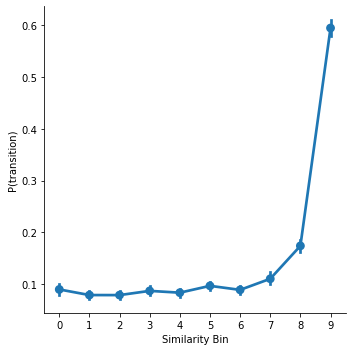

In [29]:
g = sns.catplot(x='sem_bin', y='prob', kind='point', 
                  data=pb_sem_crp)
g.set(xlabel='Similarity Bin', ylabel='P(transition)')

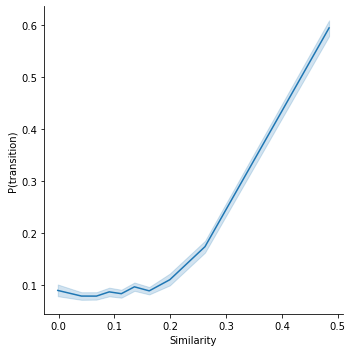

In [30]:
#using average bin value
pb_sem_crp['avg_sem_bin_mean'] = pb_sem_crp.groupby('sem_bin')['sem_bin_mean'].transform('mean')
g = sns.relplot(x='avg_sem_bin_mean', y='prob', data=pb_sem_crp, kind='line')
g.set(xlabel='Similarity', ylabel='P(transition)')

In [31]:
pb_sem_dist_fact = events_new.groupby("subject").apply(pb.pd_dist_fact,
                                                       rec_itemnos=None, 
                                                       itemno_column='item_num_new', 
                                                       list_index=['subject', 'session', 'list'], 
                                                       dist_mat=sem_sims, 
                                                       sim_columns=None, 
                                                       is_similarity=True, 
                                                       dist_columns=None,
                                                       skip_first_n=0,
                                                       pres_type="WORD", rec_type="REC_WORD", type_column='type', ret_counts=False
                                                       ).to_frame(name='sem_fact').reset_index()

pb_sem_dist_fact

,subject,sem_fact
0,R1004D,0.666667
1,R1013E,0.709021
2,R1015J,0.479365
3,R1016M,0.662442
4,R1021D,0.738065
...,...,...
234,R1616S,0.733506
235,R1617S,0.613218
236,R1626S,0.655570
237,R1627T,0.659571


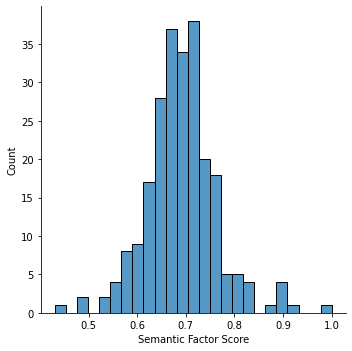

In [32]:
g = sns.displot(x='sem_fact', data=pb_sem_dist_fact)
g.set(xlabel='Semantic Factor Score')